In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Data\Train.csv",
                parse_dates=["date"])
df.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,57f879e70d3c5fc2a98102d64c9fd84e,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886
1,a5442b0c7c33d0a811e7661e556b2de8,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455
2,305cb1486ed8610c00b37007926cb2c4,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704
3,f2c1ecc9993f0071df91ba178450498c,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0,455.201
4,e460830ae295e55d2216ebdc761ab9a6,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0,1164.877


<AxesSubplot:>

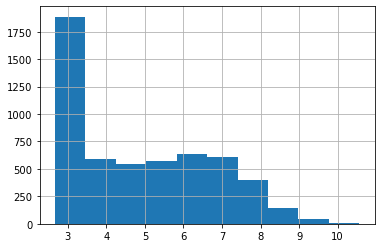

In [3]:
df["log_time_spent"] = np.log(df["time_spent"])
df["log_time_spent"].hist()

In [4]:
def convert_Date_Obj(df):
    """
    Accecps a Data Frame and a date object and extracts its corresponding Year Month and Date
    """
    
    df["Year"] = df.date.dt.year
    df["Month"] = df.date.dt.month
    df["Date"] = df.date.dt.day
    df["Day_of_Year"] = df.date.dt.dayofyear
    df["Week_Of_Year"] = df.date.dt.weekofyear
    df["Quarter"] = df.date.dt.quarter
    df["Day_Of_Week"] = df.date.dt.dayofweek
    df.drop("date", axis=1, inplace=True)
    
    return df

In [5]:
df_new = convert_Date_Obj(df)
df_new.head()

<ipython-input-4-d1471cc7cbcb>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["Week_Of_Year"] = df.date.dt.weekofyear


,session_id,session_number,client_agent,device_details,purchased,added_in_cart,checked_out,time_spent,log_time_spent,Year,Month,Date,Day_of_Year,Week_Of_Year,Quarter,Day_Of_Week
0,57f879e70d3c5fc2a98102d64c9fd84e,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,1,0,0,236.886,5.467579,2020,1,22,22,4,1,2
1,a5442b0c7c33d0a811e7661e556b2de8,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,1,0,0,1277.455,7.152625,2020,2,27,58,9,1,3
2,305cb1486ed8610c00b37007926cb2c4,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,0,0,0,21.704,3.077497,2019,8,1,213,31,3,3
3,f2c1ecc9993f0071df91ba178450498c,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,0,1,0,455.201,6.120739,2019,12,30,364,1,4,0
4,e460830ae295e55d2216ebdc761ab9a6,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,0,0,0,1164.877,7.060371,2019,9,10,253,37,3,1


In [6]:
df_new.drop("session_id", axis=1, inplace=True)
df_new.head()

,session_number,client_agent,device_details,purchased,added_in_cart,checked_out,time_spent,log_time_spent,Year,Month,Date,Day_of_Year,Week_Of_Year,Quarter,Day_Of_Week
0,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,1,0,0,236.886,5.467579,2020,1,22,22,4,1,2
1,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,1,0,0,1277.455,7.152625,2020,2,27,58,9,1,3
2,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,0,0,0,21.704,3.077497,2019,8,1,213,31,3,3
3,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,0,1,0,455.201,6.120739,2019,12,30,364,1,4,0
4,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,0,0,0,1164.877,7.060371,2019,9,10,253,37,3,1


In [7]:
def convert_string_to_categorical(df):
    """
    Accepts a Data Frame and converts the String to Pandas category
    """
    
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
    return df

In [9]:
# Converting String to categoricals
df_cat = convert_string_to_categorical(df_new)
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   session_number  5429 non-null   int64   
 1   client_agent    5269 non-null   category
 2   device_details  5429 non-null   category
 3   purchased       5429 non-null   int64   
 4   added_in_cart   5429 non-null   int64   
 5   checked_out     5429 non-null   int64   
 6   time_spent      5429 non-null   float64 
 7   log_time_spent  5429 non-null   float64 
 8   Year            5429 non-null   int64   
 9   Month           5429 non-null   int64   
 10  Date            5429 non-null   int64   
 11  Day_of_Year     5429 non-null   int64   
 12  Week_Of_Year    5429 non-null   int64   
 13  Quarter         5429 non-null   int64   
 14  Day_Of_Week     5429 non-null   int64   
dtypes: category(2), float64(2), int64(11)
memory usage: 593.6 KB


In [10]:
def fill_numbers(df):
    """
    Receives a DataFrame and fills its missing String values with numbers
    """
    
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Converting the Categorical values to numbers. 
            # Generally NULL will be filled as -1, we want to change it to 0(ZERO)
            df[label] = pd.Categorical(content).codes+1
    return df

In [13]:
df_final = fill_numbers(df_cat)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_number  5429 non-null   int64  
 1   client_agent    5429 non-null   int16  
 2   device_details  5429 non-null   int8   
 3   purchased       5429 non-null   int64  
 4   added_in_cart   5429 non-null   int64  
 5   checked_out     5429 non-null   int64  
 6   time_spent      5429 non-null   float64
 7   log_time_spent  5429 non-null   float64
 8   Year            5429 non-null   int64  
 9   Month           5429 non-null   int64  
 10  Date            5429 non-null   int64  
 11  Day_of_Year     5429 non-null   int64  
 12  Week_Of_Year    5429 non-null   int64  
 13  Quarter         5429 non-null   int64  
 14  Day_Of_Week     5429 non-null   int64  
dtypes: float64(2), int16(1), int64(11), int8(1)
memory usage: 567.4 KB


In [14]:
df_final.isna().sum()

session_number    0
client_agent      0
device_details    0
purchased         0
added_in_cart     0
checked_out       0
time_spent        0
log_time_spent    0
Year              0
Month             0
Date              0
Day_of_Year       0
Week_Of_Year      0
Quarter           0
Day_Of_Week       0
dtype: int64

In [15]:
X = df_final.drop(["time_spent", "log_time_spent"], axis=1)
y = df_final["log_time_spent"]
len(X), len(y)

(5429, 5429)

In [16]:
from sklearn.model_selection import train_test_split

np.random.seed(55)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

len(X_train), len(y_train), len(X_val), len(y_val)

(4343, 4343, 1086, 1086)

In [17]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Building RMSLE error function
def rmsle(y_test, y_preds):
    """
    Returns Root Mean Squared Log error
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    # predicting on the Test Data
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_val)
    
    # converting the Traget Logarithmic value to its corresponding Exponential value.
    train_preds_actual = np.exp(train_preds)
    valid_preds_actual = np.exp(valid_preds)
    y_train_actual = np.exp(y_train)
    y_val_actual = np.exp(y_val)
    
    scores = {"Log Training MAE": mean_absolute_error(y_train, train_preds),
             "Log Valid MAE": mean_absolute_error(y_val, valid_preds),
             "Log Training RMSLE": rmsle(y_train, train_preds),
             "Log Valid RMSLE": rmsle(y_val, valid_preds),
             "Log Training R2 Score": r2_score(y_train, train_preds),
             "Log Valid R2 Score": r2_score(y_val, valid_preds),
             
             "Actual Training MAE": mean_absolute_error(y_train_actual, train_preds_actual),
             "Actual Valid MAE": mean_absolute_error(y_val_actual, valid_preds_actual),
             "Actual Training RMSLE": rmsle(y_train_actual, train_preds_actual),
             "Actual Valid RMSLE": rmsle(y_val_actual, valid_preds_actual),
             "Actual Training R2 Score": r2_score(y_train_actual, train_preds_actual),
             "Actual Valid R2 Score": r2_score(y_val_actual, valid_preds_actual)}
             
    return scores   


In [16]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>xgboost -1.100 (0.037)
>Lasso -1.294 (0.034)
>RandForest -1.115 (0.038)
>stacking -1.085 (0.039)


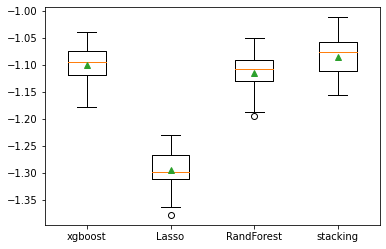

In [47]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor as xgb
from sklearn.linear_model import Lasso as lso

from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot
 

 
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('xgboost', xgb(seed=0,
                                  reg_lambda=0,
                                  reg_alpha=40,
                                  n_estimators=180,
                                  min_child_weight=4,
                                  max_depth=8,
                                  gamma=1,
                                  colsample_bytree=0.89999)))
    
    level0.append(('Lasso', lso(alpha=0.1)))
    
    level0.append(('RandForest', RandomForestRegressor(n_estimators=370,
                                                       min_samples_split=19,
                                                       min_samples_leaf=1,
                                                       max_features='sqrt',
                                                       max_depth=10,
                                                       n_jobs=-1,
                                                       bootstrap=True,
                                                       random_state=42)))
    # define meta learner model
    level1 = CatBoostRegressor(depth=5,
                               iterations=140,
                               learning_rate=0.09,
                               random_state=42)
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['xgboost'] = xgb(seed=0,
                            reg_lambda=0,
                            reg_alpha=40,
                            n_estimators=180,
                            min_child_weight=4,
                            max_depth=8,
                            gamma=1,
                            colsample_bytree=0.89999)
    
    models['Lasso'] = lso(alpha=0.1)
    
    models['RandForest'] = RandomForestRegressor(n_estimators=370,
                                                       min_samples_split=19,
                                                       min_samples_leaf=1,
                                                       max_features='sqrt',
                                                       max_depth=10,
                                                       n_jobs=-1,
                                                       bootstrap=True,
                                                       random_state=42)
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# define dataset
# X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [48]:
len(X)

5429

In [49]:
level0 = list()
level0.append(('xgboost', xgb(seed=0,
                              reg_lambda=0,
                              reg_alpha=40,
                              n_estimators=180,
                              min_child_weight=4,
                              max_depth=8,
                              gamma=1,
                              colsample_bytree=0.89999)))
    
level0.append(('Lasso', lso(alpha=0.1)))
    
level0.append(('RandForest', RandomForestRegressor(n_estimators=370,
                                                       min_samples_split=19,
                                                       min_samples_leaf=1,
                                                       max_features='sqrt',
                                                       max_depth=10,
                                                       n_jobs=-1,
                                                       bootstrap=True,
                                                       random_state=42)))
# define meta learner model
level1 = CatBoostRegressor(depth=5,
                           iterations=140,
                           learning_rate=0.09,
                           random_state=42)

# define the stacking ensemble
stk_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

# fit the model on all available data
stk_model.fit(X, y)

# make a prediction for one example
#data = [[0.59332206,-0.56637507,1.34808718,-0.57054047,-0.72480487,1.05648449,0.77744852,0.07361796,0.88398267,2.02843157,1.01902732,0.11227799,0.94218853,0.26741783,0.91458143,-0.72759572,1.08842814,-0.61450942,-0.69387293,1.69169009]]
#yhat = model.predict(data)
#print('Predicted Value: %.3f' % (yhat))

0:	learn: 1.7233209	total: 3.9ms	remaining: 543ms
1:	learn: 1.6713784	total: 7.58ms	remaining: 523ms
2:	learn: 1.6280433	total: 11.7ms	remaining: 532ms
3:	learn: 1.5899553	total: 15ms	remaining: 511ms
4:	learn: 1.5581206	total: 19ms	remaining: 513ms
5:	learn: 1.5302027	total: 23.1ms	remaining: 516ms
6:	learn: 1.5074940	total: 26.9ms	remaining: 512ms
7:	learn: 1.4865643	total: 30.3ms	remaining: 500ms
8:	learn: 1.4696060	total: 33.7ms	remaining: 490ms
9:	learn: 1.4535502	total: 37.5ms	remaining: 487ms
10:	learn: 1.4417568	total: 40.7ms	remaining: 478ms
11:	learn: 1.4304094	total: 44.5ms	remaining: 475ms
12:	learn: 1.4225812	total: 47.8ms	remaining: 467ms
13:	learn: 1.4139785	total: 51.7ms	remaining: 465ms
14:	learn: 1.4075191	total: 55ms	remaining: 459ms
15:	learn: 1.4017106	total: 58.3ms	remaining: 452ms
16:	learn: 1.3964720	total: 61.7ms	remaining: 446ms
17:	learn: 1.3923102	total: 65.9ms	remaining: 447ms
18:	learn: 1.3883744	total: 69.2ms	remaining: 440ms
19:	learn: 1.3851931	total: 7

StackingRegressor(cv=5,
                  estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.89999, gamma=1,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=4, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators...
                                            reg_lambda=0, scale_pos_weight=None,
                                            seed=0, subsamp

In [50]:
show_scores(stk_model)

{'Log Training MAE': 0.9799645333460575,
 'Log Valid MAE': 1.0055544678685142,
 'Log Training RMSLE': 0.20713089580071148,
 'Log Valid RMSLE': 0.2124437848172785,
 'Log Training R2 Score': 0.5044683953633128,
 'Log Valid R2 Score': 0.4812654762783697,
 'Actual Training MAE': 513.2591604914758,
 'Actual Valid MAE': 518.8426196019439,
 'Actual Training RMSLE': 1.2438492941815182,
 'Actual Valid RMSLE': 1.2704743518859742,
 'Actual Training R2 Score': 0.11594893882702584,
 'Actual Valid R2 Score': 0.10313715186167816}

In [20]:
stk_pred = stk_model.predict(X_val)
stk_pred

array([4.0195047 , 5.03608275, 6.33975276, ..., 4.25264818, 6.33590434,
       4.997596  ])

In [21]:
stk_pred[:10]

array([4.0195047 , 5.03608275, 6.33975276, 4.23638277, 6.58694639,
       3.92418175, 4.54668417, 4.42000472, 6.10458859, 3.50894599])

## xgboost..

In [22]:
import xgboost as xgb

In [23]:
#xgr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6594975539639095, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01634714303249965, max_delta_step=0, max_depth=9,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.42320618378477715, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [24]:
#xgr.fit(X_train, y_train)

[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 

[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=9
[12:20:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 172 extra nod

[12:20:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=9
[12:20:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=9
[12:20:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=9
[12:20:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=9
[12:20:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=9
[12:20:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 312 extra nod

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6594975539639095, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01634714303249965, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.42320618378477715, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [25]:
#show_scores(xgr)

{'Log Training MAE': 0.8738140624121997,
 'Log Valid MAE': 1.1068692527825086,
 'Log Training RMSLE': 0.18339089308627995,
 'Log Valid RMSLE': 0.23226818997248927,
 'Log Training R2 Score': 0.5897814301634734,
 'Log Valid R2 Score': 0.35801998914671074,
 'Actual Training MAE': 505.38507921671146,
 'Actual Valid MAE': 556.4406605656661,
 'Actual Training RMSLE': 1.132882097113664,
 'Actual Valid RMSLE': 1.414528259566983,
 'Actual Training R2 Score': 0.08843478300421459,
 'Actual Valid R2 Score': 0.015850533030535963}

## catboost..

In [45]:
from catboost import CatBoostRegressor

In [47]:
%%time

# Different CatBoostRegressor hyperparameters
CatBoost_grid_CV = {"depth": np.arange(5, 20, 1),
                    "learning_rate": np.arange(0.01, 0.1, 0.01),
                    "iterations": np.arange(10, 150, 10)
                   }

catboost_gs_model = GridSearchCV(CatBoostRegressor(random_state=42),
                       param_grid=CatBoost_grid_CV,
                       cv=3,
                       n_jobs=-1,          
                       verbose=True
                        )

#catboost_gs_model.fit(X_train, y_train)

Fitting 3 folds for each of 1890 candidates, totalling 5670 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 215.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 518.7min
[Parallel(n_jobs=-1)]: Done 5670 out of 5670 | elapsed: 521.3min finished


0:	learn: 1.7355100	total: 59.3ms	remaining: 8.24s
1:	learn: 1.6942850	total: 61.8ms	remaining: 4.26s
2:	learn: 1.6586123	total: 63.8ms	remaining: 2.91s
3:	learn: 1.6288104	total: 65.8ms	remaining: 2.24s
4:	learn: 1.6026825	total: 67.8ms	remaining: 1.83s
5:	learn: 1.5811443	total: 69.9ms	remaining: 1.56s
6:	learn: 1.5608006	total: 71.9ms	remaining: 1.36s
7:	learn: 1.5408048	total: 73.8ms	remaining: 1.22s
8:	learn: 1.5274353	total: 75.9ms	remaining: 1.1s
9:	learn: 1.5160002	total: 81.2ms	remaining: 1.05s
10:	learn: 1.5032052	total: 83.5ms	remaining: 979ms
11:	learn: 1.4918631	total: 85.6ms	remaining: 913ms
12:	learn: 1.4824004	total: 87.7ms	remaining: 857ms
13:	learn: 1.4746319	total: 89.9ms	remaining: 809ms
14:	learn: 1.4692760	total: 92.1ms	remaining: 767ms
15:	learn: 1.4623462	total: 94.2ms	remaining: 730ms
16:	learn: 1.4569079	total: 96.5ms	remaining: 698ms
17:	learn: 1.4527697	total: 98.6ms	remaining: 668ms
18:	learn: 1.4487438	total: 101ms	remaining: 641ms
19:	learn: 1.4436667	tot

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002161483C1F0>,
             n_jobs=-1,
             param_grid={'depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'iterations': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140]),
                         'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             verbose=True)

In [48]:
#catboost_gs_model.best_params_
# best params===> {'depth': 5, 'iterations': 140, 'learning_rate': 0.09}

{'depth': 5, 'iterations': 140, 'learning_rate': 0.09}

In [49]:
#show_scores(catboost_gs_model)

{'Log Training MAE': 1.0366659043141961,
 'Log Valid MAE': 1.1221674785277878,
 'Log Training RMSLE': 0.21411613183475525,
 'Log Valid RMSLE': 0.2328726818725645,
 'Log Training R2 Score': 0.47712294585930404,
 'Log Valid R2 Score': 0.38210332888188026,
 'Actual Training MAE': 520.2268738671007,
 'Actual Valid MAE': 539.5659944418039,
 'Actual Training RMSLE': 1.2773228757270771,
 'Actual Valid RMSLE': 1.3863681292459356,
 'Actual Training R2 Score': 0.11372135562915342,
 'Actual Valid R2 Score': 0.0714197691867553}

## lightgbm ... (Does not work)

In [71]:
!pip install lightgbm

In [40]:
import lightgbm as lgb


In [ ]:
 params = {'application':'regression','num_iterations': 5000,
                  'learning_rate':0.05, 'early_stopping_round':50,
                  'metric':'l1'} # Default parameters
        params["num_leaves"] = int(round(num_leaves))         45, 60
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)      (0.1, 0.9) 
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)      (0.8, 1)
        params['max_depth'] = int(round(max_depth))           (9, 13 )
        params['min_split_gain'] = min_split_gain             (0.001, 0.1)
        params['min_child_weight'] = min_child_weight         (30, 50)

In [43]:
params = {"objective": "regression",
          "boosting_type": 'gbdt',
          "num_iterations": 5000,
          "learning_rate": 0.1,
          "metric": 11,
          "max_depth": 8}

n_estimators = 100
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_val, label=y_val)
watchlist = [d_valid]

lgb_model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)

# creating a model with the RandomizedSearchCV option.
#changed the n_iter=500 
# lgb_model = RandomizedSearchCV(lgb(n_jobs=-1,
#                                    random_state=42),
#                                      param_distributions=lgb_grid,
#                                      cv=3,
#                                      n_iter=500,
#                                      verbose=True)

# Fitting the model rs_model
# lgb_model.fit(lgb_grid, X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 13
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 4.909365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [45]:
X_train

,session_number,client_agent,device_details,purchased,added_in_cart,checked_out,Year,Month,Date,Day_of_Year,Week_Of_Year,Quarter,Day_Of_Week
786,363,695,17,0,0,0,2020,3,29,89,13,1,6
2305,66,323,7,0,0,0,2019,9,30,273,40,3,0
993,44,81,8,0,0,0,2019,8,11,223,32,3,6
536,33,330,7,1,0,0,2020,3,22,82,12,1,6
4645,1001,202,7,0,0,0,2019,11,17,321,46,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,1969,657,17,0,0,0,2020,1,11,11,2,1,5
968,198,428,16,0,0,0,2019,11,23,327,47,4,5
4391,1012,40,2,0,0,0,2019,10,31,304,44,4,3
4762,913,396,16,0,0,0,2019,9,15,258,37,3,6


## Converting the Test Data into desired format and predicting on it

In [24]:
#converted the date to datetime instead of only being object
df_test = pd.read_csv("Data\Test.csv",
                parse_dates=["date"])
df_test.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out
0,0bf72b05b2cf70dc5e28c3c09f9c4f97,99,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,Desktop - IE,2020-01-07,1,0,0
1,6bc696d99954e4f1367e845465186aef,935,Product/160393 Android/4.3 Device/samsung_GT-I...,Android Phone - Android,2020-02-13,0,0,0
2,3d8611a5ea0f621d205b67f09f663a89,902,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-14,1,0,0
3,a0351545c032fd0da36289410c6c3354,3223,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2020-01-26,0,0,0
4,dd8999772b0ab27225fb05e5df2f1da6,231,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-29,0,0,0


In [25]:
df_new = convert_Date_Obj(df_test)
df_new.head()

<ipython-input-4-d1471cc7cbcb>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["Week_Of_Year"] = df.date.dt.weekofyear


,session_id,session_number,client_agent,device_details,purchased,added_in_cart,checked_out,Year,Month,Date,Day_of_Year,Week_Of_Year,Quarter,Day_Of_Week
0,0bf72b05b2cf70dc5e28c3c09f9c4f97,99,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,Desktop - IE,1,0,0,2020,1,7,7,2,1,1
1,6bc696d99954e4f1367e845465186aef,935,Product/160393 Android/4.3 Device/samsung_GT-I...,Android Phone - Android,0,0,0,2020,2,13,44,7,1,3
2,3d8611a5ea0f621d205b67f09f663a89,902,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,1,0,0,2019,10,14,287,42,4,0
3,a0351545c032fd0da36289410c6c3354,3223,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,0,0,0,2020,1,26,26,4,1,6
4,dd8999772b0ab27225fb05e5df2f1da6,231,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,Desktop - Chrome,0,0,0,2020,1,29,29,5,1,2


In [26]:
df_new.drop("session_id", axis=1, inplace=True)
df_new.head()

,session_number,client_agent,device_details,purchased,added_in_cart,checked_out,Year,Month,Date,Day_of_Year,Week_Of_Year,Quarter,Day_Of_Week
0,99,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,Desktop - IE,1,0,0,2020,1,7,7,2,1,1
1,935,Product/160393 Android/4.3 Device/samsung_GT-I...,Android Phone - Android,0,0,0,2020,2,13,44,7,1,3
2,902,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,1,0,0,2019,10,14,287,42,4,0
3,3223,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,0,0,0,2020,1,26,26,4,1,6
4,231,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,Desktop - Chrome,0,0,0,2020,1,29,29,5,1,2


In [27]:
df_new.isna().sum()

session_number     0
client_agent      59
device_details     0
purchased          0
added_in_cart      0
checked_out        0
Year               0
Month              0
Date               0
Day_of_Year        0
Week_Of_Year       0
Quarter            0
Day_Of_Week        0
dtype: int64

In [28]:
df_cat = convert_string_to_categorical(df_new)
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   session_number  2327 non-null   int64   
 1   client_agent    2268 non-null   category
 2   device_details  2327 non-null   category
 3   purchased       2327 non-null   int64   
 4   added_in_cart   2327 non-null   int64   
 5   checked_out     2327 non-null   int64   
 6   Year            2327 non-null   int64   
 7   Month           2327 non-null   int64   
 8   Date            2327 non-null   int64   
 9   Day_of_Year     2327 non-null   int64   
 10  Week_Of_Year    2327 non-null   int64   
 11  Quarter         2327 non-null   int64   
 12  Day_Of_Week     2327 non-null   int64   
dtypes: category(2), int64(11)
memory usage: 231.5 KB


In [29]:
df_final = fill_numbers(df_cat)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   session_number  2327 non-null   int64
 1   client_agent    2327 non-null   int16
 2   device_details  2327 non-null   int8 
 3   purchased       2327 non-null   int64
 4   added_in_cart   2327 non-null   int64
 5   checked_out     2327 non-null   int64
 6   Year            2327 non-null   int64
 7   Month           2327 non-null   int64
 8   Date            2327 non-null   int64
 9   Day_of_Year     2327 non-null   int64
 10  Week_Of_Year    2327 non-null   int64
 11  Quarter         2327 non-null   int64
 12  Day_Of_Week     2327 non-null   int64
dtypes: int16(1), int64(11), int8(1)
memory usage: 206.9 KB


In [30]:
df_final.isna().sum()

session_number    0
client_agent      0
device_details    0
purchased         0
added_in_cart     0
checked_out       0
Year              0
Month             0
Date              0
Day_of_Year       0
Week_Of_Year      0
Quarter           0
Day_Of_Week       0
dtype: int64

### Predicticing with XGBoost....

In [77]:
xgr.fit(X, y)

[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=7
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 

[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nod

[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=9
[00:55:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 264 extra nod

[00:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=9
[00:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=9
[00:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=9
[00:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=9
[00:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=9
[00:55:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 384 extra nod

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6594975539639095, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01634714303249965, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.42320618378477715, tree_method='exact',
             validate_parameters=1, verbosity=2)

In [78]:
show_scores(xgr)

{'Log Training MAE': 0.8981323137021827,
 'Log Valid MAE': 0.9177886331047334,
 'Log Training RMSLE': 0.1882795352699541,
 'Log Valid RMSLE': 0.1922733466303257,
 'Log Training R2 Score': 0.5701425117361423,
 'Log Valid R2 Score': 0.5529498523451344,
 'Actual Training MAE': 510.36865833027576,
 'Actual Valid MAE': 511.01409352814346,
 'Actual Training RMSLE': 1.159588077048284,
 'Actual Valid RMSLE': 1.180650423801804,
 'Actual Training R2 Score': 0.083716150939253,
 'Actual Valid R2 Score': 0.088545546373344}

In [79]:
xgr_model_pred = xgr.predict(df_final)
xgr_model_pred[:10]

array([5.9350295, 4.070839 , 5.2318225, 4.4294577, 4.51112  , 6.132624 ,
       5.8151402, 3.9029896, 4.465367 , 6.106897 ], dtype=float32)

In [80]:
xgr_pred_df = pd.DataFrame()
xgr_pred_df["time_spent"] = xgr_model_pred
xgr_pred_df["time_spent"] = np.exp(xgr_pred_df["time_spent"])
xgr_pred_df.head()

,time_spent
0,378.051147
1,58.606110
2,187.133545
3,83.885910
4,91.023697


In [81]:
xgr_pred_df.to_csv("Predictions\predictions_xgr_boost_tuned_fi.csv", index=False)

### Predicticing with CatBoost....

In [65]:
# Training the model on complete dataset
#{'depth': 5, 'iterations': 140, 'learning_rate': 0.09}
#cbr_model_tuned = CatBoostRegressor(depth=5,
                                    iterations=140,
                                    learning_rate=0.09,
                                    random_state=42
                                   )
#cbr_model_tuned.fit(X, y)

0:	learn: 1.7353998	total: 4.2ms	remaining: 584ms
1:	learn: 1.6950912	total: 7.66ms	remaining: 529ms
2:	learn: 1.6598746	total: 11.2ms	remaining: 510ms
3:	learn: 1.6305710	total: 14.7ms	remaining: 499ms
4:	learn: 1.6046903	total: 18.3ms	remaining: 495ms
5:	learn: 1.5834973	total: 21.7ms	remaining: 484ms
6:	learn: 1.5637591	total: 25.4ms	remaining: 483ms
7:	learn: 1.5444375	total: 29.1ms	remaining: 480ms
8:	learn: 1.5314657	total: 32.9ms	remaining: 478ms
9:	learn: 1.5195882	total: 36.6ms	remaining: 475ms
10:	learn: 1.5072797	total: 40.5ms	remaining: 476ms
11:	learn: 1.4992310	total: 44.7ms	remaining: 477ms
12:	learn: 1.4907630	total: 48.3ms	remaining: 472ms
13:	learn: 1.4822972	total: 51.9ms	remaining: 467ms
14:	learn: 1.4761924	total: 64.7ms	remaining: 539ms
15:	learn: 1.4695090	total: 68.7ms	remaining: 532ms
16:	learn: 1.4653424	total: 72.5ms	remaining: 524ms
17:	learn: 1.4606117	total: 75.8ms	remaining: 514ms
18:	learn: 1.4564509	total: 78.7ms	remaining: 501ms
19:	learn: 1.4515415	to

In [66]:
#show_scores(cbr_model_tuned)

{'Log Training MAE': 1.0479145227135556,
 'Log Valid MAE': 1.072907829038251,
 'Log Training RMSLE': 0.21620560768630842,
 'Log Valid RMSLE': 0.22298905300702473,
 'Log Training R2 Score': 0.4657741053022396,
 'Log Valid R2 Score': 0.43373441081586506,
 'Actual Training MAE': 524.5674548291238,
 'Actual Valid MAE': 526.3207542027476,
 'Actual Training RMSLE': 1.2911976300290937,
 'Actual Valid RMSLE': 1.3271260190341907,
 'Actual Training R2 Score': 0.11897699556631258,
 'Actual Valid R2 Score': 0.09202216906267158}

In [67]:
#cbr_model_tuned_pred = cbr_model_tuned.predict(df_final)
#cbr_model_tuned_pred[:10]

array([6.50488343, 4.23746048, 5.29184543, 4.5860512 , 4.72573983,
       6.87145242, 5.44562285, 3.9882112 , 4.45476089, 6.37828348])

In [68]:
#cbr_pred_df = pd.DataFrame()
#cbr_pred_df["time_spent"] = cbr_model_tuned_pred
#cbr_pred_df["time_spent"] = np.exp(cbr_pred_df["time_spent"])
#cbr_pred_df.head()

,time_spent
0,668.397749
1,69.231813
2,198.709793
3,98.106262
4,112.813930


In [69]:
#cbr_pred_df.to_csv("Predictions\predictions_cat_boost_tuned_fi.csv", index=False)

In [82]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

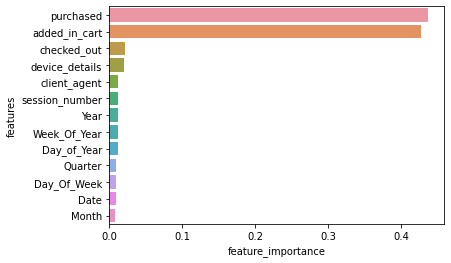

In [84]:
# XG Bosst feature importance
plot_features(X.columns, xgr.feature_importances_)

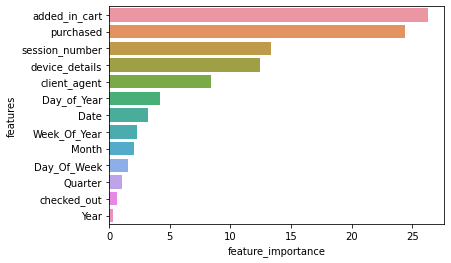

In [85]:
#Cat Boost feature importance
plot_features(X.columns, cbr_model_tuned.get_feature_importance())

### Predicting with Stacking Ensemble with multiple Algorithms

In [51]:
len(df_final)

2327

In [52]:
stk_model_pred = stk_model.predict(df_final)
stk_model_pred[:10]

array([6.28951722, 4.04833649, 5.7323571 , 4.61746276, 4.60266223,
       6.43585774, 5.91957954, 4.15283189, 4.59423092, 6.51666866])

In [53]:
stk_pred_df = pd.DataFrame()
stk_pred_df["time_spent"] = stk_model_pred
stk_pred_df["time_spent"] = np.exp(stk_pred_df["time_spent"])
stk_pred_df.head()

,time_spent
0,538.893102
1,57.302055
2,308.696038
3,101.236844
4,99.749519


In [54]:
stk_pred_df.to_csv("Predictions\predictions_stk_pred2.csv", index=False)